In [26]:
from pytorch_lightning import Trainer
import active_catinous.FastGramDynamicMemoryBrainAge as braincatsmodel
from active_catinous.FastGramDynamicMemoryBrainAge import FastGramDynamicMemoryBrainAge
from datasets.BrainAgeDataset import BrainAgeDataset
from datasets.BrainAgeContinuous import BrainAgeContinuous

import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
import sklearn 
from sklearn.metrics import confusion_matrix, auc, roc_curve
import torch
import pandas as pd
import seaborn as sns
import pickle
from py_jotools import mut, slurm, cache
import numpy as np
import gc

import hashlib
import dill
import active_catinous.utils as cutils

from sklearn.metrics import mean_absolute_error

from models.AgePredictor import EncoderRegressor
from models.unet3d import EncoderModelGenesis

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
from glob import glob
import datetime 
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


choosing a color palette for results 

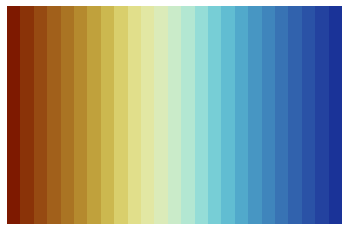

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

mapname = 'roma'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
x = np.linspace(0, 100, 25)[None, :]
plt.imshow(x, aspect='auto',cmap=colormap)
plt.axis('off')
plt.show()

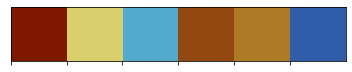

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

mapname = 'roma'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
#colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
#x = np.linspace(0, 100, 25)[None, :]
#plt.imshow(x, aspect='auto',cmap=colormap)
#plt.axis('off')
#plt.show()
colormap = ListedColormap([cm_data[0], cm_data[85],cm_data[180], cm_data[20], cm_data[45], cm_data[227]], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')
sns.palplot(sns.color_palette())

In [3]:
def test_model(model, ds, device):
    output = []
    target = []
    model.grammatrices = []

    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def test_hparams(hparams, dev='cuda'):
    device = torch.device(dev)
    test_phil15 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='test', res='1.5T Philips'), batch_size=4, num_workers=4)
    test_phil30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='test', res='3.0T Philips'), batch_size=4, num_workers=4)
    test_30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='test', res='3.0T'), batch_size=4, num_workers=4)
    
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams, train=False)
    
    target_15, output_15 = test_model(model, test_phil15, device)
    print('test phil 15', mean_absolute_error(target_15, output_15))
    target_30, output_30 = test_model(model, test_phil30, device)
    print('test phil 30', mean_absolute_error(target_30, output_30))
    target, output = test_model(model, test_30, device)
    print('test 30', mean_absolute_error(target, output))
    
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)
    for i in range(3):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not braincatsmodel.is_cached(base_params[-1]):
            #print('not cached')
            #slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)
            pass
        else:            
            exp_name = cutils.get_expname(base_params[-1])

            max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
            df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))
            
            df_temp = df_temp.loc[df_temp['val_mae_1.5T Philips']==df_temp['val_mae_1.5T Philips']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
            
            if os.path.exists(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv'):
                df_mem = pd.read_csv(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv')
            else:
                print(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv', 'not existing')
                df_mem = None
    return df, df_mem

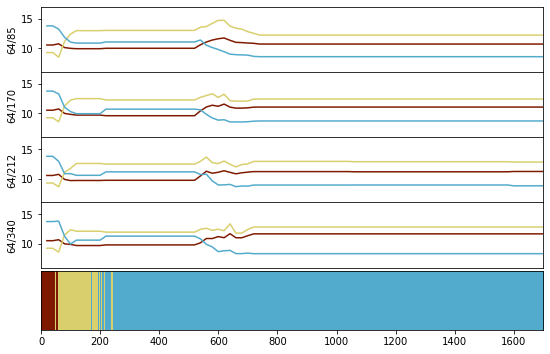

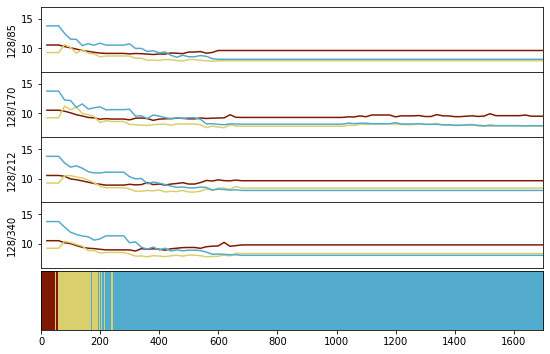

In [4]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 8.17, #performance for first domain after base training
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 8,
         'transition_phase_after':0.7
        }


hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)

ds = BrainAgeContinuous(hparams['datasetfile'], transition_phase_after=hparams['transition_phase_after'], seed=hparams['seed'])
scan = ds.df.Scanner == '3.0T Philips'
scan[ds.df.Scanner == '3.0T'] = 2

startbugdets = [85, 170, 212, 340]
memorymaximas = [64, 128]

for mm in memorymaximas:
    fig, axes = plt.subplots(5,1, figsize=(9, 6))

    plt.subplots_adjust(hspace=0.0)
    for i, sb in enumerate(startbugdets):
        hparams['startbudget'] = sb
        hparams['memorymaximum'] = mm
        res, _ = res_data_for_params(hparams)
        ax = axes[i]
        sns.lineplot(data=res, y='val_mae_1.5T Philips', x='idx', err_style=None,ax=ax, label='1.5T Phil')
        sns.lineplot(data=res, y='val_mae_3.0T Philips', x='idx', err_style=None, ax=ax, label='3.0T Phil')
        sns.lineplot(data=res, y='val_mae_3.0T', x='idx', err_style=None,ax=ax, label='3.0T')

        ax.set_ylim(6, 17)
        ax.set_xlim(0, 85)
        ax.get_xaxis().set_visible(False)
        ax.get_legend().remove()

        ax.set_ylabel(f'{mm}/{sb}')
    axes[4].imshow(np.tile(scan,(200,1)), cmap=ListedColormap(colormap.colors[:3]))
    axes[4].get_yaxis().set_visible(False)
    axes[4].get_yaxis()
    
    plt.savefig(cutils.RESPATH + f'prelim_casa_{mm}.pdf')

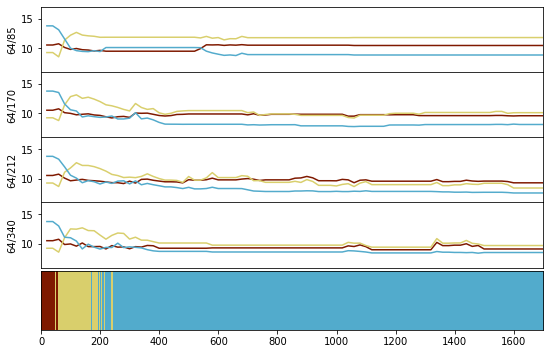

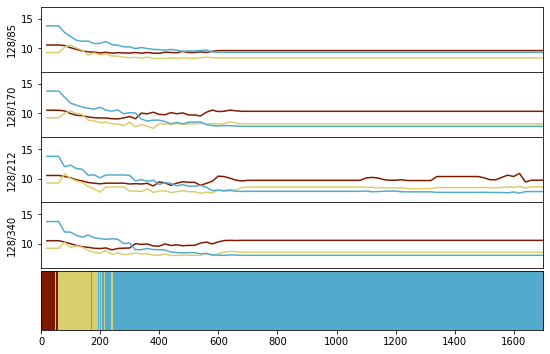

In [78]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 7.0, #performance for first domain after base training
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 8,
         'transition_phase_after':0.7
        }


hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)

ds = BrainAgeContinuous(hparams['datasetfile'], transition_phase_after=hparams['transition_phase_after'], seed=hparams['seed'])
scan = ds.df.Scanner == '3.0T Philips'
scan[ds.df.Scanner == '3.0T'] = 2

startbugdets = [85, 170, 212, 340]
memorymaximas = [64, 128]

for mm in memorymaximas:
    fig, axes = plt.subplots(5,1, figsize=(9, 6))

    plt.subplots_adjust(hspace=0.0)
    for i, sb in enumerate(startbugdets):
        hparams['startbudget'] = sb
        hparams['memorymaximum'] = mm
        res, _ = res_data_for_params(hparams)
        ax = axes[i]
        sns.lineplot(data=res, y='val_mae_1.5T Philips', x='idx', err_style=None,ax=ax, label='1.5T Phil')
        sns.lineplot(data=res, y='val_mae_3.0T Philips', x='idx', err_style=None, ax=ax, label='3.0T Phil')
        sns.lineplot(data=res, y='val_mae_3.0T', x='idx', err_style=None,ax=ax, label='3.0T')

        ax.set_ylim(6, 17)
        ax.set_xlim(0, 85)
        ax.get_xaxis().set_visible(False)
        ax.get_legend().remove()

        ax.set_ylabel(f'{mm}/{sb}')
    axes[4].imshow(np.tile(scan,(200,1)), cmap=ListedColormap(colormap.colors[:3]))
    axes[4].get_yaxis().set_visible(False)
    axes[4].get_yaxis()
    
    plt.savefig(cutils.RESPATH + f'prelim_casa_7_{mm}.pdf')

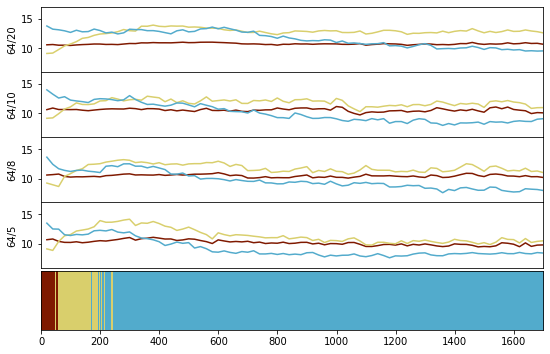

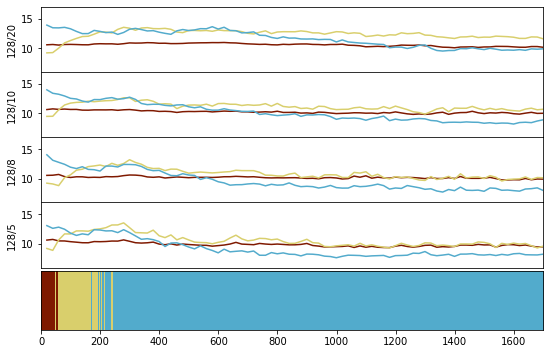

In [5]:
newcmp = ListedColormap([sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]], name='OrangeBlue')

hparams={'continuous': True,
         'use_memory': True,
         'naive_continuous': True,
         'naive_continuous_rate':15,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 32,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'transition_phase_after':0.7
        }



hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)

ds = BrainAgeContinuous(hparams['datasetfile'], transition_phase_after=hparams['transition_phase_after'], seed=hparams['seed'])
scan = ds.df.Scanner == '3.0T Philips'
scan[ds.df.Scanner == '3.0T'] = 2

continuous_rate = [20, 10, 8, 5]
memorymaximas = [64, 128]

for mm in memorymaximas:
    fig, axes = plt.subplots(5,1, figsize=(9, 6))

    plt.subplots_adjust(hspace=0.0)
    for i, cr in enumerate(continuous_rate):
        hparams['naive_continuous_rate'] = cr
        hparams['memorymaximum'] = mm
        try:
            res, _ = res_data_for_params(hparams)
            ax = axes[i]
            sns.lineplot(data=res, y='val_mae_1.5T Philips', x='idx', err_style=None,ax=ax, label='1.5T Phil')
            sns.lineplot(data=res, y='val_mae_3.0T Philips', x='idx', err_style=None, ax=ax, label='3.0T Phil')
            sns.lineplot(data=res, y='val_mae_3.0T', x='idx', err_style=None,ax=ax, label='3.0T')

            ax.set_ylim(6, 17)
            ax.set_xlim(0, 85)
            ax.get_xaxis().set_visible(False)
            ax.get_legend().remove()


            ax.set_ylabel(f'{mm}/{cr}')
        except Exception as e:
            pass
    axes[4].imshow(np.tile(scan,(200,1)), cmap=ListedColormap(colormap.colors[:3]))
    axes[4].get_yaxis().set_visible(False)
    axes[4].get_yaxis()
    
    plt.savefig(cutils.RESPATH + f'prelim_naive_{mm}.pdf')

In [8]:
df_res = pd.read_csv('prelim_res_7.csv')
df_res.groupby(['mm', 'sb', 'method', 'scanner']).mean()

postfix        mae
mm  sb  method sb  scanner                         
64  5   naive  5   1.5T Philips        2   7.729076
                   3.0T                2   8.160189
                   3.0T Philips        2   8.832136
    8   naive  8   1.5T Philips        2   7.702984
                   3.0T                2   7.999015
                   3.0T Philips        2   8.957492
    10  naive  10  1.5T Philips        2   7.384521
                   3.0T                2  10.350707
                   3.0T Philips        2   9.619753
    20  naive  20  1.5T Philips        2   8.477852
                   3.0T                2   9.043636
                   3.0T Philips        2   8.955070
    85  casa   85  1.5T Philips        2   8.683188
                   3.0T                2   8.636880
                   3.0T Philips        2   8.716804
    170 casa   170 1.5T Philips        2   8.056425
                   3.0T                2   8.278039
                   3.0T Philips        2   8.804853
    212 casa   212 1.5T Philips        2   7.527250
                   3.0T                2   7.995058
                   3.0T Philips        2   9.194262
    340 casa   340 1.5T Philips        2   7.598436
                   3.0T                2   9.529443
                   3.0T Philips        2   9.310281
128 5   naive  5   1.5T Philips        2   6.726108
                   3.0T                2   8.014977
                   3.0T Philips        2   9.304569
    8   naive  8   1.5T Philips        2   7.331467
                   3.0T                2   9.095922
                   3.0T Philips        2   9.339664
    10  naive  10  1.5T Philips        2   7.325589
                   3.0T                2   8.448513
                   3.0T Philips        2   9.332989
    20  naive  20  1.5T Philips        2   7.614660
                   3.0T                2   9.359535
                   3.0T Philips        2   9.106227
    85  casa   85  1.5T Philips        2   7.905328
                   3.0T                2   9.239459
                   3.0T Philips        2  10.233076
    170 casa   170 1.5T Philips        2   7.852266
                   3.0T                2   9.103457
                   3.0T Philips        2  10.335955
    212 casa   212 1.5T Philips        2   7.420770
                   3.0T                2   8.988997
                   3.0T Philips        2  10.095637
    340 casa   340 1.5T Philips        2   8.975650
                   3.0T                2   8.130002
                   3.0T Philips        2   9.758101

In [8]:
device = torch.device('cuda')

outfile = 'prelim_res_on_val_7.csv'
dssplit = 'val'

startbudgets = [85, 170, 212, 340]
memorymaximas = [64, 128]



test_phil15 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split=dssplit, res='1.5T Philips'), batch_size=2, num_workers=4)
test_phil30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split=dssplit, res='3.0T Philips'), batch_size=2, num_workers=4)
test_30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split=dssplit, res='3.0T'), batch_size=2, num_workers=4)

hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 7.0, #performance for first domain after base training
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 8,
         'transition_phase_after':0.7
        }


hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)
out_scan = []
out_mm = []
out_sb = []
out_post = []
out_mae = []
out_method = []
for mm in memorymaximas:
    for sb in startbudgets:
        for j in range(3):
            hparams['startbudget'] = sb
            hparams['memorymaximum'] = mm
            hparams['run_postfix'] = j+1
            model, _, _, _ = braincatsmodel.trained_model(hparams, train=False)

            print(f'{mm} {sb} {j}')
            if model is not None:

                target, output = test_model(model, test_phil15, device)
                out_scan.append('1.5T Philips')
                out_mm.append(mm)
                out_sb.append(sb)
                out_post.append(j+1)
                out_mae.append(mean_absolute_error(target, output))
                out_method.append('casa')

                target, output = test_model(model, test_phil30, device)
                out_scan.append('3.0T Philips')
                out_mm.append(mm)
                out_sb.append(sb)
                out_post.append(j+1)
                out_mae.append(mean_absolute_error(target, output))
                out_method.append('casa')


                target, output = test_model(model, test_30, device)
                out_scan.append('3.0T')
                out_mm.append(mm)
                out_sb.append(sb)
                out_post.append(j+1)
                out_mae.append(mean_absolute_error(target, output))
                out_method.append('casa')
            else:
                print('model is none')

            del model
            torch.cuda.empty_cache()
            print('_________________________________')
#df_results = pd.read_csv('prelim_res_7.csv')
df_results_val = pd.DataFrame({'mm':out_mm, 'sb': out_sb, 'postfix': out_post, 'scanner': out_scan, 'mae': out_mae, 'method': out_method})
df_results_val.to_csv(outfile, index=False)

init
{}
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_a847951867.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_a847951867.pt
64 85 0
_________________________________
init
{}
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_2_5f52646c30.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_2_5f52646c30.pt
64 85 1
_________________________________
init
{}
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_3_7cbd7db971.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_3_7cbd7db971.pt
64 85 2
_________________________________
init
{}
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_

In [9]:
device = torch.device('cuda')

outfile = 'prelim_res_on_val_7.csv'
dssplit = 'val'

test_phil15 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split=dssplit, res='1.5T Philips'), batch_size=2, num_workers=4)
test_phil30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split=dssplit, res='3.0T Philips'), batch_size=2, num_workers=4)
test_30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split=dssplit, res='3.0T'), batch_size=2, num_workers=4)

hparams={'continuous': True,
         'use_memory': True,
         'naive_continuous': True,
         'naive_continuous_rate':15,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 32,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'transition_phase_after':0.7
        }


hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)

continuous_rate = [20, 8, 10, 5]
memorymaximas = [64, 128]

out_scan = []
out_mm = []
out_sb = []
out_post = []
out_mae = []
out_method = []
for mm in memorymaximas:
    for cr in continuous_rate:
        for j in range(3):
            hparams['naive_continuous_rate'] = cr
            hparams['memorymaximum'] = mm
            hparams['run_postfix'] = j+1
            try:
                model, _, _, _ = braincatsmodel.trained_model(hparams, train=False)

                print(f'{mm} {cr} {j}')
                if model is not None:
                    target, output = test_model(model, test_phil15, device)
                    out_scan.append('1.5T Philips')
                    out_mm.append(mm)
                    out_sb.append(cr)
                    out_post.append(j+1)
                    out_mae.append(mean_absolute_error(target, output))
                    out_method.append('naive')

                    target, output = test_model(model, test_phil30, device)
                    out_scan.append('3.0T Philips')
                    out_mm.append(mm)
                    out_sb.append(cr)
                    out_post.append(j+1)
                    out_mae.append(mean_absolute_error(target, output))
                    out_method.append('naive')


                    target, output = test_model(model, test_30, device)
                    out_scan.append('3.0T')
                    out_mm.append(mm)
                    out_sb.append(cr)
                    out_post.append(j+1)
                    out_mae.append(mean_absolute_error(target, output))
                    out_method.append('naive')


                del model
                torch.cuda.empty_cache()
                print('_________________________________')
            except Exception as e:
                pass
df_results = pd.read_csv(outfile)
#df_results = df_results_val.append(pd.DataFrame({'mm':out_mm, 'sb': out_sb, 'postfix': out_post, 'scanner': out_scan, 'mae': out_mae, 'method': out_method}))
df_results = df_results_val.append(pd.DataFrame({'mm':out_mm, 'sb': out_sb, 'postfix': out_post, 'scanner': out_scan, 'mae': out_mae, 'method': out_method}))
df_results.to_csv(outfile, index=False)

init
{}
/project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_dc31f490a9.pt
Read: /project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_dc31f490a9.pt
64 20 0
_________________________________
init
{}
/project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf07_2_56f13cc785.pt
Read: /project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf07_2_56f13cc785.pt
64 20 1
_________________________________
init
{}
/project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf07_3_2e1f1a95a5.pt
Read: /project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf07_3_2e1f1a95a5.pt
64 20 2
_________________________________
init
{}
/project/catinous/active_catinous/trained_models/cont_naive_brainds_

In [12]:
df_results.groupby(['method', 'mm', 'sb', 'scanner']).mean()

postfix        mae
method mm  sb  scanner                         
casa   64  85  1.5T Philips      2.0   9.470152
               3.0T              2.0   8.223624
               3.0T Philips      2.0  12.259340
           170 1.5T Philips      2.0   8.570013
               3.0T              2.0   7.611737
               3.0T Philips      2.0  10.437444
           212 1.5T Philips      2.0   8.539928
               3.0T              2.0   7.074572
               3.0T Philips      2.0   8.560569
           340 1.5T Philips      2.5   8.332199
               3.0T              2.5   8.015065
               3.0T Philips      2.5  10.040372
       128 85  1.5T Philips      2.0   9.326478
               3.0T              2.0   8.780524
               3.0T Philips      2.0   8.090064
           170 1.5T Philips      2.0  10.386065
               3.0T              2.0   7.304300
               3.0T Philips      2.0   7.272527
           212 1.5T Philips      2.0   9.664054
               3.0T              2.0   7.295092
               3.0T Philips      2.0   6.992870
           340 1.5T Philips      2.0  10.856004
               3.0T              2.0   7.482471
               3.0T Philips      2.0   7.813498
naive  64  5   1.5T Philips      2.0   8.194019
               3.0T              2.0   7.949040
               3.0T Philips      2.0  11.255066
           8   1.5T Philips      2.0   8.267846
               3.0T              2.0   7.479797
               3.0T Philips      2.0  12.065197
           10  1.5T Philips      1.0   8.236128
               3.0T              1.0   8.645761
               3.0T Philips      1.0  11.893107
           20  1.5T Philips      2.0   8.858272
               3.0T              2.0   8.951611
               3.0T Philips      2.0  13.769710
       128 5   1.5T Philips      2.0   7.523865
               3.0T              2.0   7.785938
               3.0T Philips      2.0  10.648072
           8   1.5T Philips      2.0   7.890717
               3.0T              2.0   7.477626
               3.0T Philips      2.0  11.456317
           10  1.5T Philips      2.0   8.038807
               3.0T              2.0   8.415462
               3.0T Philips      2.0  11.949164
           20  1.5T Philips      2.0   8.102455
               3.0T              2.0   9.366606
               3.0T Philips      2.0  13.151650

In [16]:
df_results_val.groupby(['method', 'mm', 'sb', 'scanner']).std()

postfix       mae
method mm  sb  scanner                        
casa   64  85  1.5T Philips      1.0  0.416151
               3.0T              1.0  0.377526
               3.0T Philips      1.0  0.196565
           170 1.5T Philips      1.0  1.204873
               3.0T              1.0  0.534953
               3.0T Philips      1.0  0.749705
           212 1.5T Philips      1.0  1.112958
               3.0T              1.0  0.449178
               3.0T Philips      1.0  0.613371
           340 1.5T Philips      1.0  0.748612
               3.0T              1.0  0.098863
               3.0T Philips      1.0  1.017959
       128 85  1.5T Philips      1.0  0.553325
               3.0T              1.0  0.192902
               3.0T Philips      1.0  0.034568
           170 1.5T Philips      1.0  0.950531
               3.0T              1.0  0.307299
               3.0T Philips      1.0  0.405169
           212 1.5T Philips      1.0  0.370666
               3.0T              1.0  0.233251
               3.0T Philips      1.0  0.146331
           340 1.5T Philips      1.0  0.535087
               3.0T              1.0  0.085786
               3.0T Philips      1.0  0.414199
naive  64  5   1.5T Philips      1.0  0.000000
               3.0T              1.0  0.000000
               3.0T Philips      1.0  0.000000
           8   1.5T Philips      1.0  0.090982
               3.0T              1.0  2.214420
               3.0T Philips      1.0  2.326583
           10  1.5T Philips      1.0  0.258783
               3.0T              1.0  1.626153
               3.0T Philips      1.0  2.479243
           15  1.5T Philips      1.0  0.037502
               3.0T              1.0  1.611471
               3.0T Philips      1.0  2.515415
           20  1.5T Philips      1.0  0.119728
               3.0T              1.0  1.218665
               3.0T Philips      1.0  1.611525
       128 5   1.5T Philips      1.0  0.271779
               3.0T              1.0  1.668689
               3.0T Philips      1.0  2.179949
           8   1.5T Philips      1.0  0.000000
               3.0T              1.0  0.000000
               3.0T Philips      1.0  0.000000
           10  1.5T Philips      1.0  0.004669
               3.0T              1.0  1.571873
               3.0T Philips      1.0  2.221101
           15  1.5T Philips      1.0  0.042334
               3.0T              1.0  1.421179
               3.0T Philips      1.0  2.441467
           20  1.5T Philips      1.0  0.050461
               3.0T              1.0  1.231040
               3.0T Philips      1.0  1.497899

In [44]:
def LastNlines(fname, N): 
    # opening file using with() method 
    # so that file get closed 
    # after completing work 
    with open(fname) as file: 
          
        # loop to read iterate  
        # last n lines and print it 
        for line in (file.readlines() [-N:]): 
            print(line, end ='') 

In [45]:
dt = datetime.datetime.strptime('11-12-2020', '%m-%d-%Y')

final_f = []
for f in glob('/home/mperkonigg/ServerMount/slurmoutput/activecatinous*'):    
    if datetime.datetime.fromtimestamp(os.stat(f).st_mtime)>dt:
        final_f.append(f)

In [74]:
traincount = []
labelcount = []
models = []
for f in final_f:
    with open(f) as file:
        for line in (file.readlines()): 
            if line.startswith('/project/catinous/active_catinous/'):
                if (os.path.basename(line).strip())!='cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_17e81dafaf.pt':
                    models.append(os.path.basename(line).strip())
            elif line.startswith('train counter'):
                traincount.append(int(line.split(' ')[2].strip()))
            elif line.startswith('label counter'):
                labelcount.append(int(line.split(' ')[2].strip()))
df_traincounts = pd.DataFrame({'model': models, 'tc': traincount, 'lc': labelcount})

In [70]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 8.17, #performance for first domain after base training
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 8,
         'transition_phase_after':0.7
        }


hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)

models = []
mms = []
sbs= []
postfixes = []

for mm in memorymaximas:
    for i, sb in enumerate(startbugdets):
        for i in range(3):
            hparams['startbudget'] = sb
            hparams['memorymaximum'] = mm
            hparams['run_postfix'] = i+1

            mms.append(mm)
            sbs.append(sb)
            postfixes.append(i+1)
            models.append(cutils.get_expname(hparams)+'.pt')
df_models = pd.DataFrame({'model': models, 'mm': mms, 'sb': sbs, 'postfix': postfixes})

In [69]:
startbugdets

[85, 170, 212, 340]

In [75]:
df_traincounts.merge(df_models).groupby(['mm', 'sb']).mean()

tc         lc  postfix
mm  sb                                 
64  85    83.000000  74.333333      2.0
    170   78.000000  74.333333      2.0
    212   88.333333  74.666667      2.0
    340   85.666667  74.000000      2.0
128 85   186.000000  85.000000      2.0
    170  225.666667  98.666667      2.0
    212  208.333333  89.000000      2.0
    340  208.333333  89.333333      2.0

In [79]:
res, mem = res_data_for_params(hparams)


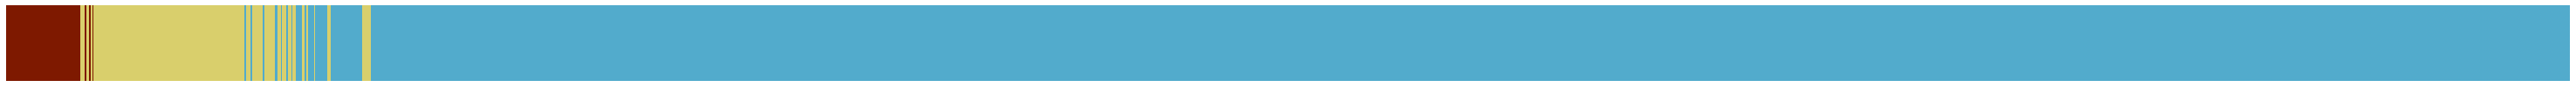

In [73]:
ds = BrainAgeContinuous(hparams['datasetfile'], transition_phase_after=0.7, seed=hparams['seed'])
scan = ds.df.Scanner == '3.0T Philips'
scan[ds.df.Scanner == '3.0T'] = 2

plt.figure(figsize=(50,1.5))
plt.imshow(np.tile(scan,(50,1)), cmap=ListedColormap(colormap.colors[:3]))
plt.axis('off')
plt.tight_layout()
plt.savefig(cutils.RESPATH + 'continous3brainclasses.png')

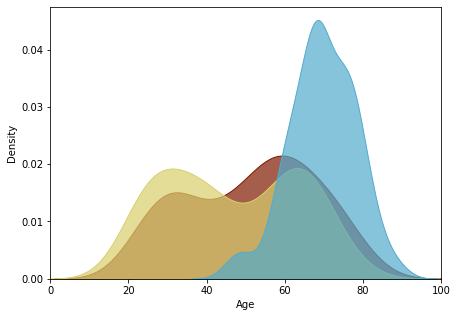

In [91]:
df = pd.read_csv('/project/catinous/brainds_split.csv')
target_phil15 = df.loc[df.Scanner=='1.5T Philips'].sample(n=100)
target_phil30 = df.loc[df.Scanner=='3.0T Philips'].sample(n=100)
target_30 = df.loc[df.Scanner=='3.0T'].sample(n=100)
fig, ax = plt.subplots(1,1, figsize=(7, 5))

ax.set_xlim([0, 100])
sns.kdeplot(target_phil15.Age, fill=True, ax=ax, label='1.5T Philips', alpha=0.7)
sns.kdeplot(target_phil30.Age, fill=True, ax=ax, label='3.0T Philips', alpha=0.7)
sns.kdeplot(target_30.Age, fill=True, ax=ax, label='3.0T Siemens', alpha=0.7)

plt.savefig(cutils.RESPATH + 'agedistribution.png')

In [80]:
target_phil15

,Unnamed: 0,ID,Scanner,Age,Image,split
161,165,IXI188,1.5T Philips,44.024641,/data/dataset/external/IXI/IXI188-Guys-0798-T1...,train
132,136,IXI157,1.5T Philips,54.425736,/data/dataset/external/IXI/IXI157-Guys-0816-T1...,base_train
309,323,IXI361,1.5T Philips,54.193018,/data/dataset/external/IXI/IXI361-Guys-0913-T1...,base_train
336,352,IXI390,1.5T Philips,41.889117,/data/dataset/external/IXI/IXI390-Guys-0931-T1...,train
118,120,IXI139,1.5T Philips,32.936345,/data/dataset/external/IXI/IXI139-Guys-0815-T1...,base_train
...,...,...,...,...,...,...
441,458,IXI501,1.5T Philips,67.112936,/data/dataset/external/IXI/IXI501-Guys-1016-T1...,val
473,492,IXI539,1.5T Philips,78.072553,/data/dataset/external/IXI/IXI539-Guys-1067-T1...,train
51,53,IXI065,1.5T Philips,23.715264,/data/dataset/external/IXI/IXI065-Guys-0744-T1...,base_train
335,351,IXI389,1.5T Philips,58.368241,/data/dataset/external/IXI/IXI389-Guys-0930-T1...,train


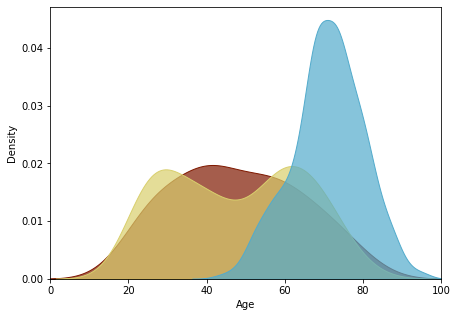

In [19]:
df = pd.read_csv('/project/catinous/brainds_split.csv')
df = df.loc[df.split=='train']
target_phil15 = df.loc[df.Scanner=='1.5T Philips']
target_phil30 = df.loc[df.Scanner=='3.0T Philips']
target_30 = df.loc[df.Scanner=='3.0T']
fig, ax = plt.subplots(1,1, figsize=(7, 5))

ax.set_xlim([0, 100])
sns.kdeplot(target_phil15.Age, fill=True, ax=ax, label='1.5T Philips', alpha=0.7)
sns.kdeplot(target_phil30.Age, fill=True, ax=ax, label='3.0T Philips', alpha=0.7)
sns.kdeplot(target_30.Age, fill=True, ax=ax, label='3.0T Siemens', alpha=0.7)

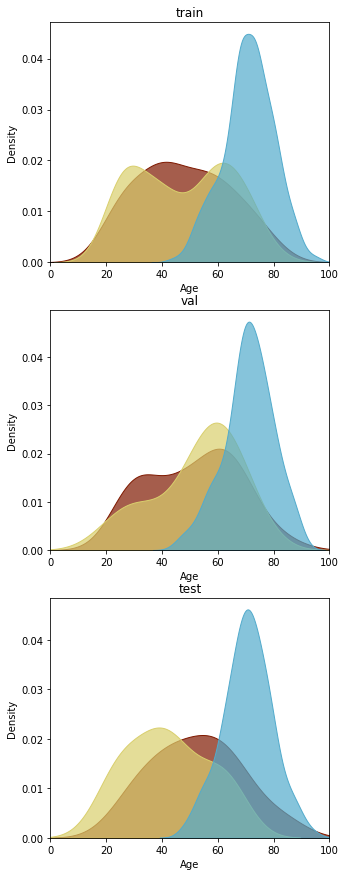

In [25]:
df = pd.read_csv('/project/catinous/brainds_split.csv')

fig, axis = plt.subplots(3,1, figsize=(5, 15))

for i, s in enumerate(['train', 'val', 'test']):

    df_split = df.loc[df.split==s]
    target_phil15 = df_split.loc[df_split.Scanner=='1.5T Philips']
    target_phil30 = df_split.loc[df_split.Scanner=='3.0T Philips']
    target_30 = df_split.loc[df_split.Scanner=='3.0T']
    
    ax = axis[i]
    
    ax.set_xlim([0, 100])
    sns.kdeplot(target_phil15.Age, fill=True, ax=ax, label='1.5T Philips', alpha=0.7)
    sns.kdeplot(target_phil30.Age, fill=True, ax=ax, label='3.0T Philips', alpha=0.7)
    sns.kdeplot(target_30.Age, fill=True, ax=ax, label='3.0T Siemens', alpha=0.7)
    ax.set_title(s)

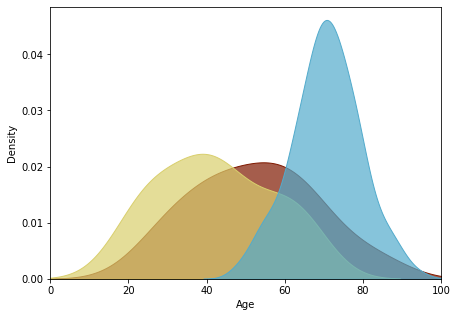

In [18]:
df = pd.read_csv('/project/catinous/brainds_split.csv')
df = df.loc[df.split=='test']
target_phil15 = df.loc[df.Scanner=='1.5T Philips']
target_phil30 = df.loc[df.Scanner=='3.0T Philips']
target_30 = df.loc[df.Scanner=='3.0T']
fig, ax = plt.subplots(1,1, figsize=(7, 5))

ax.set_xlim([0, 100])
sns.kdeplot(target_phil15.Age, fill=True, ax=ax, label='1.5T Philips', alpha=0.7)
sns.kdeplot(target_phil30.Age, fill=True, ax=ax, label='3.0T Philips', alpha=0.7)
sns.kdeplot(target_30.Age, fill=True, ax=ax, label='3.0T Siemens', alpha=0.7)